In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import tomllib
from pathlib import Path
from pandas import DataFrame
from common.utils import load_dataset
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
train_df: DataFrame = load_dataset("loan-approval-prediction-clone", index=False)
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
train_df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [4]:
train_df = train_df.astype({col: 'int32' for col in train_df.select_dtypes('int64').columns})
train_df = train_df.astype({col: 'float32' for col in train_df.select_dtypes('float64').columns})
train_df.dtypes

person_age                      int32
person_income                   int32
person_home_ownership          object
person_emp_length             float32
loan_intent                    object
loan_grade                     object
loan_amnt                       int32
loan_int_rate                 float32
loan_percent_income           float32
cb_person_default_on_file      object
cb_person_cred_hist_length      int32
loan_status                     int32
dtype: object

In [5]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade',
                    'cb_person_default_on_file']

In [6]:
train_df = pd.get_dummies(train_df,
                          columns=categorical_cols,
                          drop_first=True)

train_df.columns = [col.lower() for col in train_df.columns]

train_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_other,person_home_ownership_own,...,loan_intent_medical,loan_intent_personal,loan_intent_venture,loan_grade_b,loan_grade_c,loan_grade_d,loan_grade_e,loan_grade_f,loan_grade_g,cb_person_default_on_file_y
id,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,14,0,False,False,...,False,False,False,True,False,False,False,False,False,False
1,22,56000,6.0,4000,13.35,0.07,2,0,False,True,...,True,False,False,False,True,False,False,False,False,False
2,29,28800,8.0,6000,8.90,0.21,10,0,False,True,...,False,True,False,False,False,False,False,False,False,False
3,30,70000,14.0,12000,11.11,0.17,5,0,False,False,...,False,False,True,True,False,False,False,False,False,False
4,22,60000,2.0,6000,6.92,0.10,3,0,False,False,...,True,False,False,False,False,False,False,False,False,False


In [7]:
train_df.dtypes

person_age                       int32
person_income                    int32
person_emp_length              float32
loan_amnt                        int32
loan_int_rate                  float32
loan_percent_income            float32
cb_person_cred_hist_length       int32
loan_status                      int32
person_home_ownership_other       bool
person_home_ownership_own         bool
person_home_ownership_rent        bool
loan_intent_education             bool
loan_intent_homeimprovement       bool
loan_intent_medical               bool
loan_intent_personal              bool
loan_intent_venture               bool
loan_grade_b                      bool
loan_grade_c                      bool
loan_grade_d                      bool
loan_grade_e                      bool
loan_grade_f                      bool
loan_grade_g                      bool
cb_person_default_on_file_y       bool
dtype: object

In [38]:
train_df[train_df['person_age'] == 123]

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_other,person_home_ownership_own,...,loan_intent_medical,loan_intent_personal,loan_intent_venture,loan_grade_b,loan_grade_c,loan_grade_d,loan_grade_e,loan_grade_f,loan_grade_g,cb_person_default_on_file_y
id,,,,,,,,,,,,,,,,,,,,,
47336,123,36000,7.0,6700,10.75,0.18,4,0,False,False,...,False,True,False,True,False,False,False,False,False,False


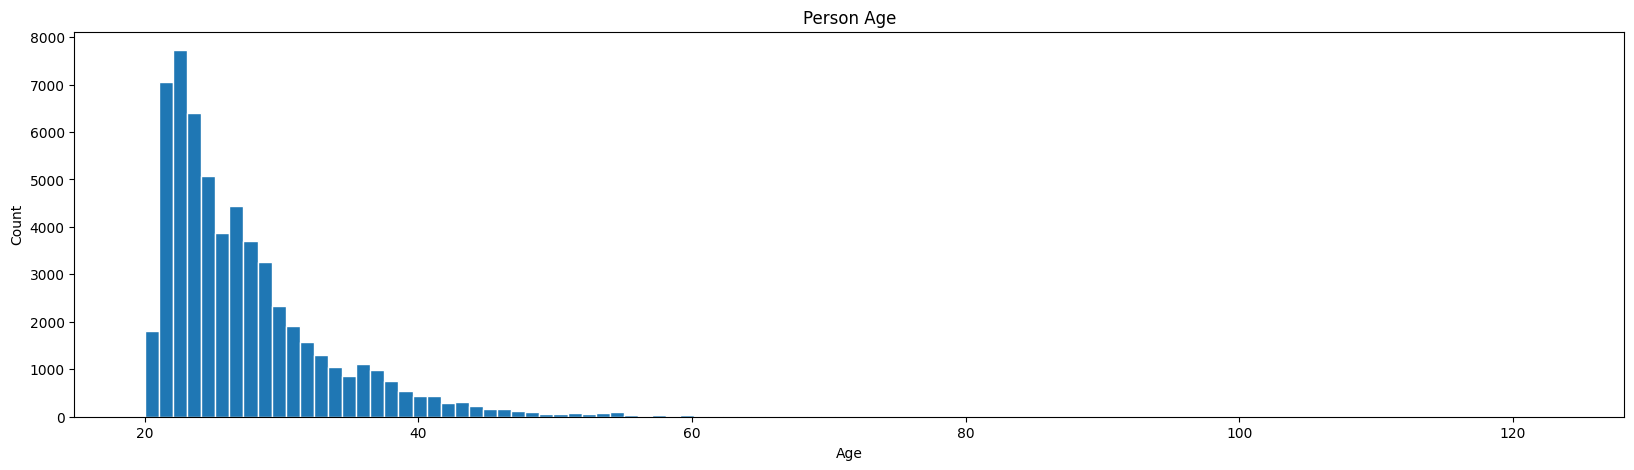

In [57]:
plt.figure(figsize=(20, 5))
plt.hist(train_df['person_age'], bins=100, edgecolor='white')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Person Age')

plt.show()